# MAML For Power Spectra Emulation

This notebook is structured as a test-bed for MAML as a tool for enahncing cosmological power spectra emulation

Here, we illustrate how a MAML trained model is able to adapt more quickly to a novel redshift distribution than standard model without the requiring a parameterisation of the redshift distribution.

Things to play with are the num. of adapatation steps when the model is being fine tuned to the new distribution, the number of shots (example power spectra) given for finetuning, and the usual NN hyperparameters. 

We use SGD here, but Adam may be more optimal in future.

In [1]:
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
import os
import copy
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# choose which training data to use
kwd = 'large'

# load in the training data
if kwd == 'small':
    if os.path.isfile('Cgg_data.npz'):
        with np.load('Cgg_data.npz') as data:
            C_ells = data['Cgg_data']
            l_arr = data['l_arr']
            Omega_b_arr = data['Omega_b_arr']
            Omega_c_arr = data['Omega_c_arr']
            h_arr = data['h_arr']
            sigma8_arr = data['sigma8_arr']
            n_s_arr = data['n_s_arr']
elif kwd == 'large':
    if os.path.isfile('Cgg_data_multi_task.npz'):
        with np.load('Cgg_data_multi_task.npz') as data:
            C_ells = data['C_ells']
            l_arr = data['l_arr']
            Omega_b_arr = data['Omega_b_arr']
            Omega_c_arr = data['Omega_c_arr']
            h_arr = data['h_arr']
            sigma8_arr = data['sigma8_arr']
            n_s_arr = data['n_s_arr']
            z0_arr = data['z0']
            dndz = data['dndz']
else:
    print('Training data file not found')

# get number of tasks and samples from data
n_tasks = np.shape(C_ells)[0]
n_samples = np.shape(C_ells)[1]
print(n_tasks, n_samples)
print(min(z0_arr), max(z0_arr))

200 50
0.10015403231366984 0.2999978540122905


In [3]:
class Trainer():
    def __init__(self, model, lr, loss_fn, decay=1e-3, seed=14):
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn
        self.seed = seed
        self.decay = decay
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=self.decay)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def train(self, x_train, y_train, epochs, batch_size=32):
        torch.manual_seed(self.seed)
        x_train = torch.tensor(x_train, dtype=torch.float32).to(self.device)
        y_train = torch.tensor(y_train, dtype=torch.float32).to(self.device)
        trainset = TensorDataset(x_train, y_train)
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        losses = []
        for _ in range(epochs):
            for x, y in trainloader:
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss_fn(y_pred, y)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
        self.model = self.model
        return losses
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        return self.model(x).detach().cpu().numpy()
    
    def finetune_predict(self, x_train, y_train, x_test, 
                         epochs, batch_size=32, reset=True):
        weights_before = copy.deepcopy(self.model.state_dict())
        self.train(x_train=x_train, y_train=y_train, epochs=epochs, batch_size=batch_size)
        pred = self.predict(x_test)
        if reset:
            self.model.load_state_dict(weights_before)
        return pred

In [4]:
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)

# We need to tile our X data so its length is n_tasks*n_samples
X = np.array([Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr]).T
X = np.tile(X, (n_tasks, 1))
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

y = C_ells
# and similarly for y, but it is not tiled since we have different Cell for each task
y = y.reshape(n_tasks*n_samples, len(l_arr))

print(np.shape(X), np.shape(y))

# split into train and test data
rng = np.random.RandomState(14)
permu = rng.permutation(n_tasks*n_samples)
X_train = X[permu[:-1]]
X_test = X[permu[-1]]
y_train = y[permu[:-1]]
y_test = y[permu[-1]]
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

CosyL = Trainer(model=model, lr=0.1, loss_fn=nn.MSELoss(), decay=1e-3, seed=14)
stand_losses = CosyL.train(X_train, y_train, 100, batch_size=2000)

(10000, 5) (10000, 29)


Obviously this ends up being bad because the model has no information on the redshift of the APS it is being asked to predict:

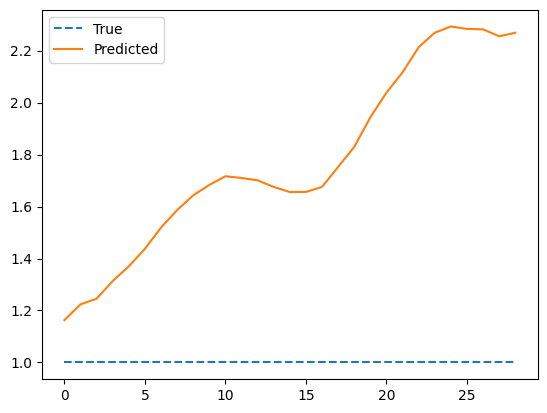

In [5]:
pred = CosyL.predict(X_test)
pred = pred.reshape(1,-1)
pred = scaler_y.inverse_transform(pred)
plt.plot(y_test/y_test, label='True', ls='--')
plt.plot(pred[0]/y_test, label='Predicted')
plt.legend()

In [6]:
class MAML():
    '''
        Class for MAML implemntation of an angular power spectrum emulator.
    '''
    def __init__(self, model, seed=14,
                 ):
        self.model = model
        self.seed = seed
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.rng = np.random.RandomState(seed)

    # convert numpy array to torch tensor
    def to_torch(self, arr):
        return ag.Variable(torch.tensor(arr, dtype=torch.float32).to(self.device))
    
    # send individual data batch to model for training step
    def train_on_batch(self, x ,y, step, loss_fn):
        x = self.to_torch(x)
        y = self.to_torch(y)
        self.model.zero_grad()
        y_pred = self.model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        for param in self.model.parameters():
            param.data -= step * param.grad.data

    # obtain predictions from model
    def predict(self, x):
        x = self.to_torch(x)
        return self.model(x).detach().cpu().numpy()
    
    # meta train the model
    def meta_train(self, x_train, y_train, 
                   inner_lr, outer_lr, loss_fn, 
                   spt_frac, outer_epochs, inner_epochs,
                   inner_decay=1e-4, outer_decay=1e-3,
                   rec_loss=True, plot_prog=False, n_shots=5):
        
        # ascertaining the number of tasks and samples
        n_tasks = y_train.shape[0]
        n_samples = y_train.shape[1]
        tasks = np.arange(n_tasks)
        tasks = self.rng.permutation(tasks) # permute the order tasks are trained

        # isolate a random task for plotting the progress of training
        if plot_prog:
            task_plot = self.rng.choice(tasks, size=1)
            print(task_plot)
            tasks= np.delete(tasks, task_plot)
            n_tasks = len(tasks)
            rand_inds = self.rng.choice(n_samples, size=n_shots+1, replace=False)
            x_shot = x_train[rand_inds[:-1],:]
            y_shot = y_train[task_plot, rand_inds[:-1]]
            scalerplot = StandardScaler()
            y_shot = scalerplot.fit_transform(y_shot)
            x_test = x_train[rand_inds[-1],:]
            y_test = y_train[task_plot, rand_inds[-1]]

        # repeat tasks so total meta train epochs is satisfied
        if n_tasks < (outer_epochs*n_tasks):
            tasks = np.tile(tasks, int(np.ceil(outer_epochs*n_tasks/n_tasks))) 
        
        loss_rec = []
        # Outer loop
        for i, task in enumerate(tasks):
            # create a deepcopy of model to reset after inner loop
            weights_before = copy.deepcopy(self.model.state_dict())

            spt_size = int(spt_frac*n_samples)
            qry_size = n_samples - spt_size
            permu = self.rng.permutation(n_samples)
            spt_inds = permu[-1*spt_size:]
            qry_inds = permu[:-1*spt_size]
            y_task = y_train[task]
            scaler_y = StandardScaler()
            y_task = scaler_y.fit_transform(y_task)

            # Inner loop
            for j in range(inner_epochs):
                innerstep = inner_lr * (1 - j * inner_decay) # linear schedule
                for start in range(0, len(spt_inds), qry_size):
                    batch_inds = spt_inds[start:start+qry_size]
                    x_spt = x_train[batch_inds,:]
                    y_spt = y_task[batch_inds,:]
                    self.train_on_batch(x_spt, y_spt, innerstep, loss_fn)
            
            # Outer loop update
            outerstep = outer_lr * (1 - i * outer_decay) # linear schedule
            for start in range(0, len(qry_inds), qry_size):
                batch_inds = qry_inds[start:start+qry_size]
                x = self.to_torch(x_train[batch_inds,:])
                y = self.to_torch(y_task[batch_inds,:])

                # Compute gradients
                self.model.zero_grad()
                y_pred = self.model(x)
                loss = loss_fn(y_pred, y)
                loss.backward()
                loss_rec.append(loss.item())

                # Reload pre-inner loop weights
                self.model.load_state_dict(weights_before)

                # Update weights
                for param in self.model.parameters():
                    param.data -= outerstep * param.grad.data

            # Plot progress every 10 outer epochs
            # Progress is measured as how quickly and accurately 
            # the model can adapt to a new task
            if plot_prog and i % 10 == 0:
                plt.cla()
                plt.title('Task: %d, Epoch: %d, Shots: %d' % (task, i, n_shots))
                weights_before = copy.deepcopy(self.model.state_dict())
                y_pred = self.predict(x_test)
                y_pred = y_pred.reshape(1,-1)
                y_pred = scalerplot.inverse_transform(y_pred)
                plt.plot(y_pred[0]/y_test[0], label='MAML iter 0', ls='-')
                for inneriter in range(32):
                    innerstep = inner_lr * (1 - inneriter * inner_decay)
                    self.train_on_batch(x_shot, y_shot, innerstep, loss_fn)
                    if (inneriter+1) % 8 == 0:
                        y_pred = self.predict(x_test)
                        y_pred = y_pred.reshape(1,-1)
                        y_pred = scalerplot.inverse_transform(y_pred)
                        plt.plot(y_pred[0]/y_test[0], label='MAML iter %d' % (inneriter+1), ls='-')
                plt.plot(y_test[0]/y_test[0], label='Truth', ls='--')
                loss = loss_fn(self.model(self.to_torch(x_test)), self.to_torch(y_test[0])).item()
                plt.legend()
                plt.xlabel('Output index')
                plt.ylabel('Predicted/Truth')
                plt.pause(0.01)
                self.model.load_state_dict(weights_before)
                print('Loss:',loss)

        if rec_loss:
            return loss_rec
        
    def finetune_predict(self, x_train, y_train, x_test, adapt_steps):
        weights_before = copy.deepcopy(self.model.state_dict())
        for i in range(adapt_steps):
            innerstep = self.inner_lr * (1 - i * self.inner_decay)
            self.train_on_batch(x_train, y_train, innerstep)
        y_pred = self.predict(x_test)
        self.model.load_state_dict(weights_before)
        return y_pred


In [8]:
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)

# set up the MAML model
X = np.array([Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr]).T
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
print(np.shape(X))
print(C_ells.shape)

CosyMAML = MAML(model=model, inner_lr=0.1, outer_lr=0.05, inner_decay=0, outer_decay=1e-3,
                loss_fn=nn.MSELoss(), seed=14)

maml_losses = CosyMAML.meta_train(x_train=X, y_train=C_ells, spt_frac=0.8, outer_epochs=1, 
                                inner_epochs=1, plot_prog=True, n_shots=15)

(50, 5)
(200, 50, 29)


TypeError: MAML.__init__() got an unexpected keyword argument 'inner_lr'

Text(0.5, 1.0, 'Training Loss')

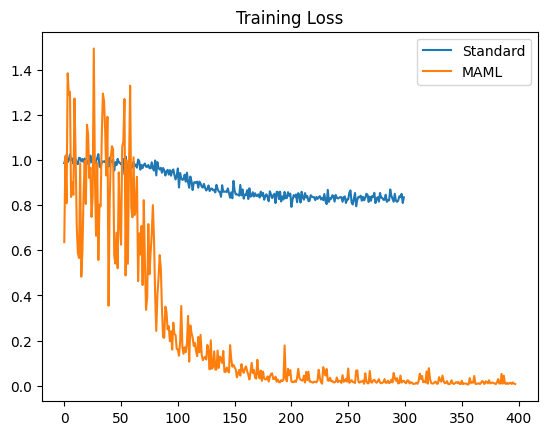

In [148]:
plt.plot(stand_losses, label='Standard')
plt.plot(maml_losses, label='MAML')
plt.legend()
plt.title('Training Loss')

[47 21 14 30 37 40 19  1  2  6 36 44 17 11 39 29]
(16, 5)


Text(0.5, 1.0, 'Test Predictions')

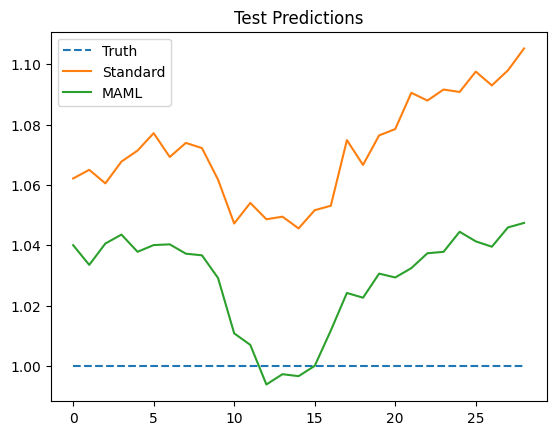

In [134]:
# Create an enitrely novel task
rng = np.random.RandomState(14)
nshot = 15
rands = rng.choice(n_samples, size=nshot+1, replace=False)
print(rands)
X = np.array([Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr]).T
X = X[rands,:]
print(X.shape)
z0_new = 0.15
z = np.linspace(0, 3., 256)
dndz = 1./(2.*z0_new) * (z / z0_new)**0.1 * np.exp(-z/z0_new)
C_ells_new = []
for i in range(nshot+1):

    cosmo = ccl.Cosmology(Omega_b=X[i,0], Omega_c=X[i,1], 
                          h=X[i,2], sigma8=X[i,3], n_s=X[i,4])
    lensTracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz))
    C_ells_new.append(ccl.angular_cl(cosmo, lensTracer, lensTracer, l_arr))

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
X_train = X[:-1,:]
X_test = X[-1,:]

y_train = C_ells_new[:-1]
y_test = C_ells_new[-1]
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

# train standard model
stand_pred = CosyL.finetune_predict(X_train, y_train, X_test, epochs=32, reset=True)
stand_pred = stand_pred.reshape(1,-1)
stand_pred = scaler_y.inverse_transform(stand_pred)

# train MAML model
maml_pred = CosyMAML.finetune_predict(X_train, y_train, X_test, adapt_steps=32)
maml_pred = maml_pred.reshape(1,-1)
maml_pred = scaler_y.inverse_transform(maml_pred)

plt.plot(y_test/y_test, label='Truth', ls='--')
plt.plot(stand_pred[0]/y_test, label='Standard')
plt.plot(maml_pred[0]/y_test, label='MAML')
plt.legend()
plt.title('Test Predictions')

In [152]:
def test_new_task(maml_class, nshot):

    # Create an enitrely novel task
    rng = np.random.RandomState(14)
    rands = rng.choice(n_samples, size=nshot+1, replace=False)
    print(rands)
    X = np.array([Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr]).T
    X = X[rands,:]
    print(X.shape)
    z0_new = 0.15
    z = np.linspace(0, 3., 256)
    dndz = 1./(2.*z0_new) * (z / z0_new)**0.1 * np.exp(-z/z0_new)
    C_ells_new = []
    for i in range(nshot+1):

        cosmo = ccl.Cosmology(Omega_b=X[i,0], Omega_c=X[i,1], 
                            h=X[i,2], sigma8=X[i,3], n_s=X[i,4])
        lensTracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz))
        C_ells_new.append(ccl.angular_cl(cosmo, lensTracer, lensTracer, l_arr))

    scaler_x = StandardScaler()
    X = scaler_x.fit_transform(X)
    X_train = X[:-1,:]
    X_test = X[-1,:]

    y_train = C_ells_new[:-1]
    y_test = C_ells_new[-1]
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train)

    # train MAML model
    maml_pred = CosyMAML.finetune_predict(X_train, y_train, X_test, adapt_steps=32)
    maml_pred = maml_pred.reshape(1,-1)
    maml_pred = scaler_y.inverse_transform(maml_pred)

    return np.mean(maml_pred[0]/y_test)

In [151]:
# Run a grid search to find optimal hyperparameters

# define the hyperparameters to search over
hypergrid = {
    'inner_lr': [0.01, 0.1, 0.5],
    'outer_lr': [0.01, 0.1, 0.5],
    'inner_decay': [1e-4, 1e-3, 1e-2],
    'outer_decay': [1e-4, 1e-3, 1e-2],
    'spt_frac': [0.5, 0.8, 0.9],
    'outer_epochs': [1, 5, 10],
    'inner_epochs': [1, 5, 10]
}

# Generate all combinations of hyperparameters
keys, values = zip(*hypergrid.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

# set up the MAML model
X = np.array([Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr]).T
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

# set up experiment
def gridsearch(modelparams, trainparams):
    best_hyper = None
    maml = MAML(model=model, **modelparams, loss_fn=nn.MSELoss(), seed=14)
    loss_rec = maml.meta_train(x_train=X, y_train=C_ells, **trainparams, rec_loss=True)
    
results = []
for 

TypeError: '<' not supported between instances of 'int' and 'list'